In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
import json

onlyfiles = [
    f for f in listdir("./daily-data") if isfile(join("./daily-data", f))
]


print(len(onlyfiles))
onlyfiles[:5]

545


['csv-2023-12-15-10-09-54-snore-1035-iPhone14-1-33.00-64.12-07-48-35.025-64.04-64.04-31.80.csv',
 'csv-2023-12-13-08-11-26-none-1035-iPhone14-0-28.26-36.29-null-NMSnore-NAvgSnore-28.48.csv',
 'csv-2023-12-15-10-47-54-none-1035-iPhone14-0-34.91-40.29-null-NMSnore-NAvgSnore-34.86.csv',
 'csv-2023-12-20-05-40-19-snore-1035-iPhone14-1-41.07-53.45-05-39-58.320-48.43-48.43-40.46.csv',
 'csv-2023-12-15-09-21-54-none-1035-iPhone14-0-30.55-51.10-null-NMSnore-NAvgSnore-30.38.csv']

In [2]:
def parse_file_name(file_name):
    pattern = r"csv-(\d{4}-\d{2}-\d{2})-(\d{2}-\d{2}-\d{2})-(\w+)-(\d+)-iPhone\d+-(\d+)-(\d+\.\d+)-(\d+\.\d+)-(\d{2}-\d{2}-\d+\.\d+|null)-(NMSnore|\d+\.\d+)-(NAvgSnore|\d+\.\d+)-(\d+\.\d+|\-inf).csv"
    match = re.match(pattern, file_name)
    if match:
        return {
            "date": match.group(1),
            "time": match.group(2),
            "event_type": match.group(3),
            "version": int(match.group(4)),
            "snore_count": int(match.group(5)),
            "avg_db": float(match.group(6)),
            "max_db": float(match.group(7)),
            "start_snore_event_timestamp": match.group(8),
            "max_snore_db": match.group(9),
            "avg_snore_db": match.group(10),
            "noise_level": match.group(11),
        }
    else:
        print(file_name)
        raise Exception("Not possible")


parsed_data = [
    parse_file_name(fn) for fn in onlyfiles if parse_file_name(fn) is not None
]

df = pd.DataFrame(parsed_data)
df["datetime"] = df.apply(
    lambda row: datetime.strptime(f"{row['date']} {row['time']}", "%Y-%m-%d %H-%M-%S"),
    axis=1,
)
df = df.drop(["date", "time"], axis=1)

df = df.sort_values(by="datetime")

df_hour = df.copy()

df_hour["hour"] = df["datetime"].dt.hour


df.reset_index(inplace=True)
df = df.drop(columns=["index"])
df.describe()

,version,snore_count,avg_db,max_db,datetime
count,545.0,545.000000,545.000000,545.000000,545
mean,1035.0,2.111927,35.592165,51.414202,2023-12-16 14:28:33.869724928
min,1035.0,0.000000,25.560000,30.060000,2023-12-13 08:00:26
25%,1035.0,0.000000,31.690000,44.390000,2023-12-13 10:16:26
50%,1035.0,0.000000,34.410000,52.900000,2023-12-15 10:32:54
75%,1035.0,3.000000,39.090000,57.060000,2023-12-18 09:23:00
max,1035.0,15.000000,69.680000,83.180000,2023-12-20 05:42:19
std,0.0,3.539216,6.638445,9.544021,NaN


In [3]:
df = df[df["event_type"] == "snore"]
df["max_snore_db"] = df["max_snore_db"].astype(float)
df["avg_snore_db"] = df["avg_snore_db"].astype(float)
df["noise_level"] = df["noise_level"].astype(float)
df.dtypes

event_type                             object
version                                 int64
snore_count                             int64
avg_db                                float64
max_db                                float64
start_snore_event_timestamp            object
max_snore_db                          float64
avg_snore_db                          float64
noise_level                           float64
datetime                       datetime64[ns]
dtype: object

In [4]:
def apply_increase_level(noise_level, avg_snore_db):
    percentage_increase = ((avg_snore_db - noise_level) / noise_level) * 100
    return percentage_increase


df["noise_increase_percentage"] = df.apply(
    lambda row: apply_increase_level(row["noise_level"], row["avg_snore_db"]), axis=1
)

df.head(15)

,event_type,version,snore_count,avg_db,max_db,start_snore_event_timestamp,max_snore_db,avg_snore_db,noise_level,datetime,noise_increase_percentage
5,snore,1035,7,31.00,44.26,07-48-35.025,31.00,31.00,27.90,2023-12-13 08:05:26,11.111111
6,snore,1035,0,30.77,52.01,07-48-35.025,48.50,42.85,29.38,2023-12-13 08:06:26,45.847515
7,snore,1035,0,30.89,51.56,07-48-35.025,50.50,44.87,29.65,2023-12-13 08:07:26,51.332209
8,snore,1035,0,30.46,50.86,07-48-35.025,48.27,41.15,30.37,2023-12-13 08:08:26,35.495555
9,snore,1035,0,28.42,54.31,07-48-35.025,54.31,46.44,31.14,2023-12-13 08:09:26,49.132948
10,snore,1035,0,27.74,57.06,07-48-35.025,53.73,47.88,29.87,2023-12-13 08:10:26,60.294610
14,snore,1035,0,30.65,54.99,07-48-35.025,52.85,45.15,30.86,2023-12-13 08:14:26,46.305898
16,snore,1035,0,28.53,50.63,07-48-35.025,50.02,48.28,30.58,2023-12-13 08:16:26,57.880968
17,snore,1035,0,29.58,51.05,07-48-35.025,49.93,38.13,30.44,2023-12-13 08:17:26,25.262812
26,snore,1035,0,26.77,54.31,07-48-35.025,49.78,49.78,28.57,2023-12-13 08:26:26,74.238712


In [5]:
df["datetime"] = pd.to_datetime(df["datetime"])

thresholds = {"Quiet": 10, "Light": 20, "Loud": 30, "Severe": 100}


def categorize_noise_level(row):
    for category, threshold in thresholds.items():
        if row["noise_increase_percentage"] < threshold:
            return category
    return "Quiet"


df["category"] = df.apply(categorize_noise_level, axis=1)

grouped = df.groupby([pd.Grouper(key="datetime", freq="15T"), "category"])

grouped_daily = df.groupby([pd.Grouper(key="datetime", freq="D"), "category"])

# grouped.head()
counts = grouped.size().reset_index(name="counts")
counts_daily = grouped_daily.size().reset_index(name="counts")

# counts
pivot_table = counts.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table_daily = counts_daily.pivot(
    index="datetime", columns="category", values="counts"
).fillna(0)

pivot_table

category,Light,Loud,Quiet,Severe
datetime,,,,
2023-12-13 08:00:00,1.0,0.0,0.0,6.0
2023-12-13 08:15:00,0.0,1.0,0.0,4.0
2023-12-13 08:30:00,1.0,3.0,0.0,6.0
2023-12-13 08:45:00,0.0,0.0,0.0,5.0
2023-12-13 09:00:00,0.0,2.0,0.0,5.0
2023-12-13 09:15:00,1.0,2.0,1.0,4.0
2023-12-13 09:30:00,0.0,0.0,0.0,15.0
2023-12-13 09:45:00,0.0,1.0,0.0,12.0
2023-12-13 10:00:00,2.0,6.0,0.0,2.0


In [6]:

pivot_table_daily

category,Light,Loud,Quiet,Severe
datetime,,,,
2023-12-13,5.0,16.0,1.0,63.0
2023-12-14,1.0,1.0,0.0,0.0
2023-12-15,4.0,8.0,3.0,50.0
2023-12-18,8.0,14.0,3.0,42.0
2023-12-20,29.0,31.0,5.0,19.0


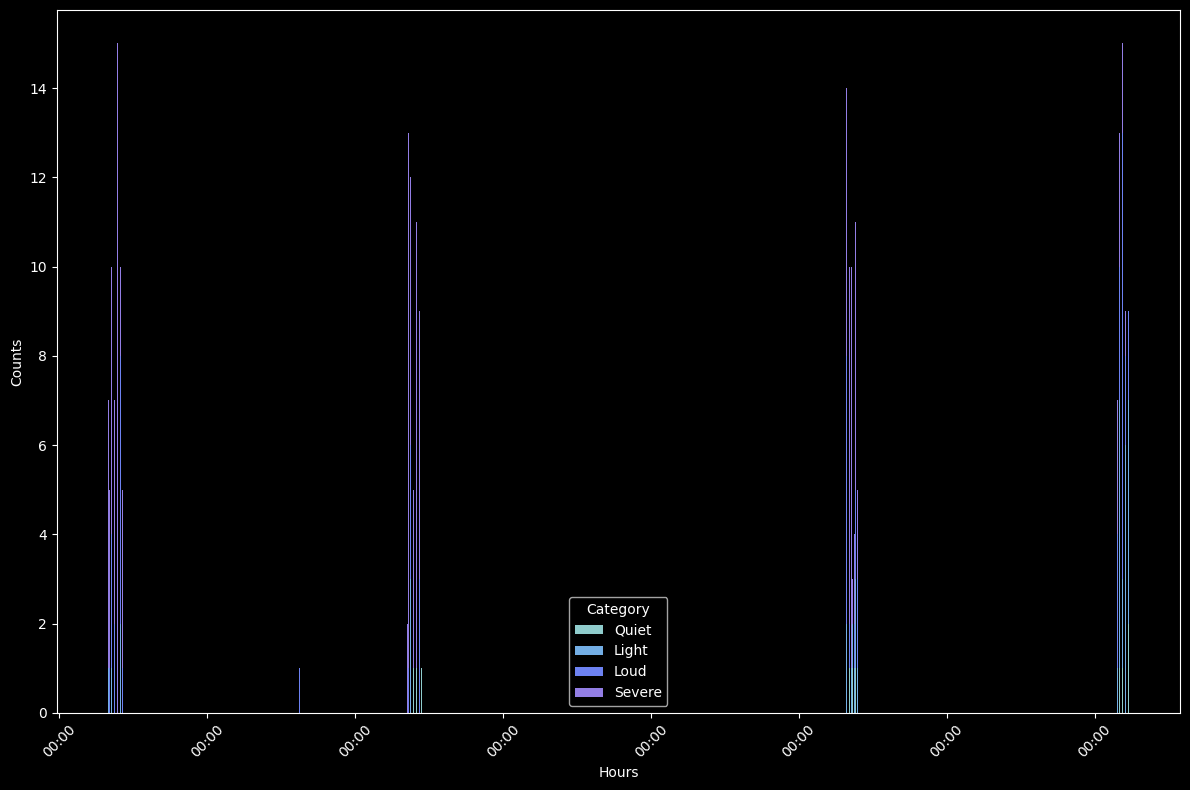

In [7]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table.index,
        pivot_table.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.005,
    )
    if bottom is None:
        bottom = pivot_table.get(category, 0)
    else:
        bottom += pivot_table.get(category, 0)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

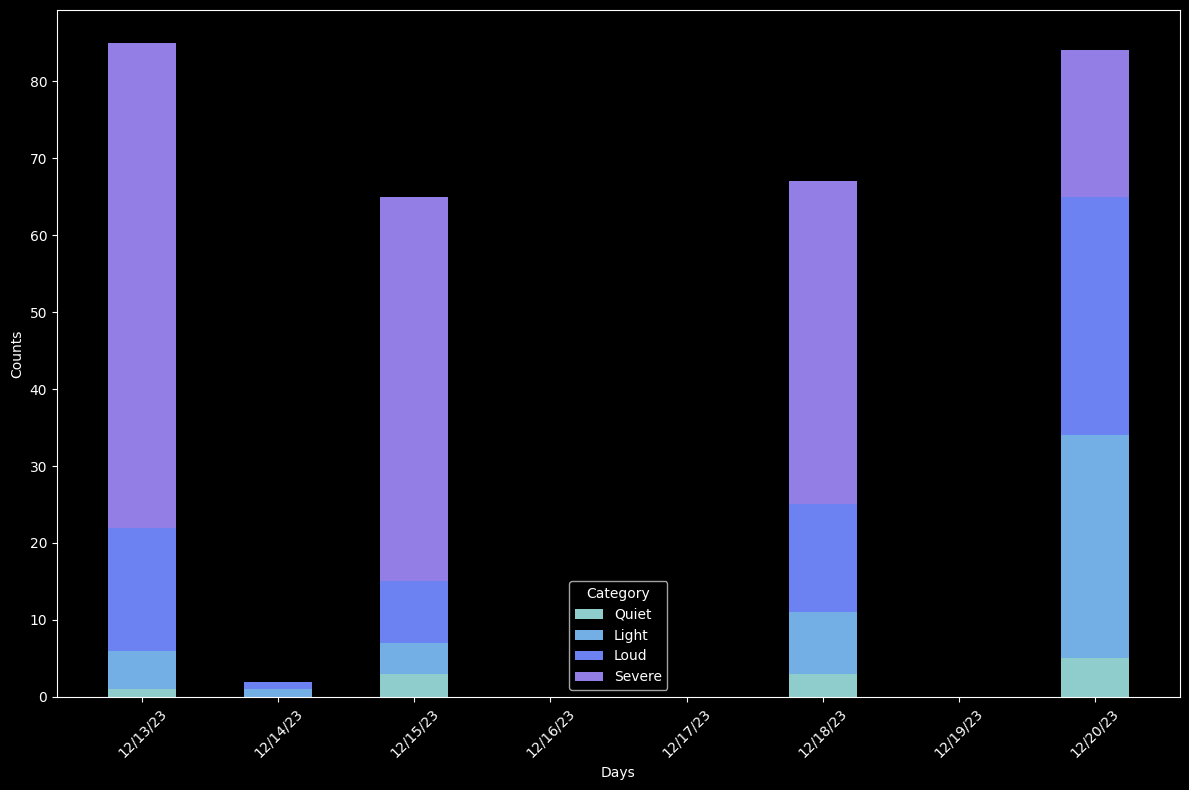

In [8]:
import matplotlib.dates as mdates


plt.style.use('dark_background')
plt.figure(figsize=(12, 8))


colors = {
    "Quiet": "#8fcccc",
    "Light": "#73aee5",
    "Loud": "#6d82f2",
    "Severe": "#937ee5",
}


bottom = None
for category, color in colors.items():
    plt.bar(
        pivot_table_daily.index,
        pivot_table_daily.get(category, 0),
        bottom=bottom,
        color=color,
        label=category,
        width=0.5,
    )
    if bottom is None:
        bottom = pivot_table_daily.get(category, 0)
    else:
        bottom += pivot_table_daily.get(category, 0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d/%y"))
# plt.xticks(pivot_table_daily.index)

plt.xlabel("Days")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title="Category")


plt.tight_layout()
plt.show()

In [9]:
pivot_table_reset_index = pivot_table.reset_index()


api_json_object = json.loads(
    pivot_table_reset_index.to_json(orient="records", date_format="iso")
)


# with open("dump_graph.json", 'w') as f:
#     json.dump(api_json_object, f, indent=4)

# f.close()

api_json_object[:5]

[{'datetime': '2023-12-13T08:00:00.000',
  'Light': 1.0,
  'Loud': 0.0,
  'Quiet': 7.0,
  'Severe': 6.0},
 {'datetime': '2023-12-13T08:15:00.000',
  'Light': 0.0,
  'Loud': 1.0,
  'Quiet': 5.0,
  'Severe': 4.0},
 {'datetime': '2023-12-13T08:30:00.000',
  'Light': 1.0,
  'Loud': 3.0,
  'Quiet': 10.0,
  'Severe': 6.0},
 {'datetime': '2023-12-13T08:45:00.000',
  'Light': 0.0,
  'Loud': 0.0,
  'Quiet': 5.0,
  'Severe': 5.0},
 {'datetime': '2023-12-13T09:00:00.000',
  'Light': 0.0,
  'Loud': 2.0,
  'Quiet': 7.0,
  'Severe': 5.0}]